In [32]:
import numpy as np
import tifffile
from skimage.measure import regionprops, label
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage.color import label2rgb
from skimage.segmentation import find_boundaries
from skimage.exposure import equalize_adapthist
from scipy.ndimage import gaussian_laplace
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.morphology import remove_small_objects

In [88]:
data = tifffile.imread('data/registered_full_movie.tif')
movie = (data - data.min(axis=(1, 2), keepdims=True)) / (np.ptp(data, axis=(1,2), keepdims=True))
roi = np.load('data/roi_auto.npy')
roi_full = roi.copy()
proj = movie.max(axis=0)

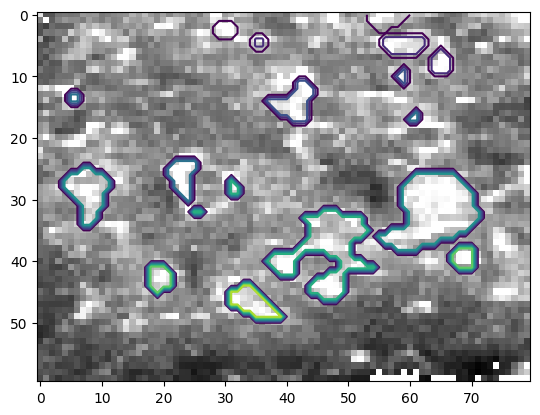

In [3]:
plt.imshow(proj, cmap='gray')
plt.contour(roi)

## Advanced ROI Splitting  
**Overarching Goal**:  
This module introduces the process of subdividing ROIs that may encompass more than one neuron. As imaging resolution and signal complexity increase, it becomes more common for automated methods to group nearby neurons into a single ROI. In this module, you will learn how to recognize these cases, enhance local structure, and split such ROIs into distinct neuronal units — all while maintaining accuracy and interpretability.

### **Identifying ROIs That Need Further Separation**  
**Learning Goal**: Learn to recognize structural or intensity features in an ROI that suggest it may contain more than one neuron.  

Some ROIs are unusually large, irregular in shape, or contain multiple peaks in intensity — features that may suggest the presence of more than one neuron. This section focuses on how to systematically identify these cases. You will learn to compute and interpret properties like compactness, peak count, and eccentricity, enabling more informed decisions about whether a region needs to be split.

**Sub-sections:**
1. Measure properties like eccentricity, area, and perimeter of existing ROIs  
2. Compute local maxima within an ROI's intensity map  
3. Mark ROIs for splitting based on peak count and shape irregularity  
4. Visualize diagnostics using labeled overlays and intensity projections  

**Measure properties like eccentricity, area, and perimeter of existing ROIs**

**Exercise** How many ROIs?

In [4]:
mask = label(roi)
props = regionprops(mask)
len(props)

18

**Exercise** Area of second ROI

In [5]:
props[1].area

np.float64(6.0)

**Exercise** Perimenter of third ROI

In [6]:
props[2].perimeter

np.float64(4.0)

**Exercise** Eccentricity of last ROI

In [7]:
props[-1].eccentricity

0.8875577748309221

**Compute local maxima within an ROI's intensity map**

**Exercise** Crop and plot ROI 11

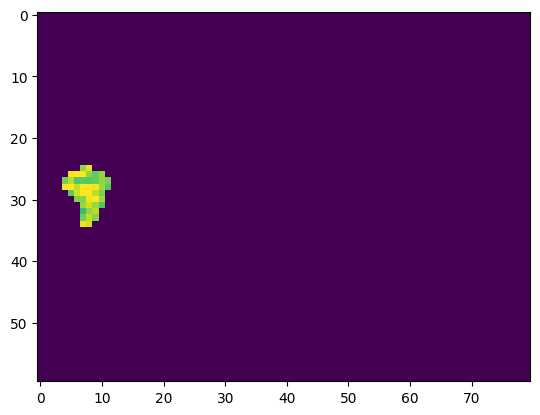

In [8]:
roi = mask == 11
roi_crop = proj * roi
plt.imshow(roi_crop)

**Exercise** Plot and crop ROI 12

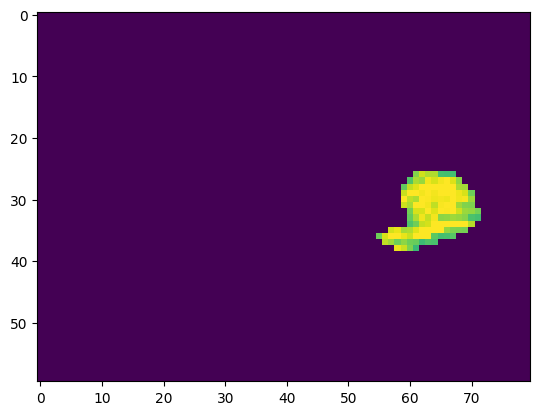

In [9]:
roi = mask == 12
roi_crop = proj * roi
plt.imshow(roi_crop)

**Exercise** Find local intensity peaks for the selected ROI

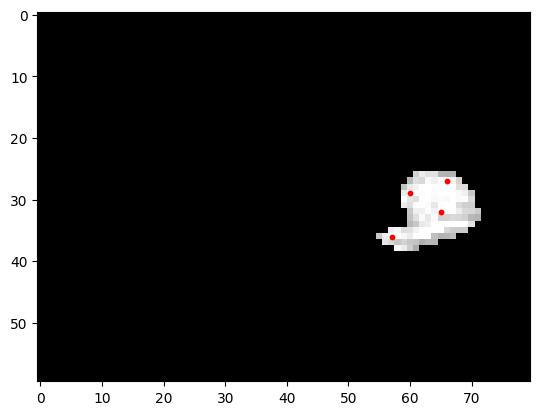

In [10]:
coords = peak_local_max(roi_crop, min_distance=5)
plt.imshow(roi_crop, cmap='gray')
plt.scatter(coords[:, 1], coords[:, 0], s=10, c='r')

**Exercise** Find boundaries

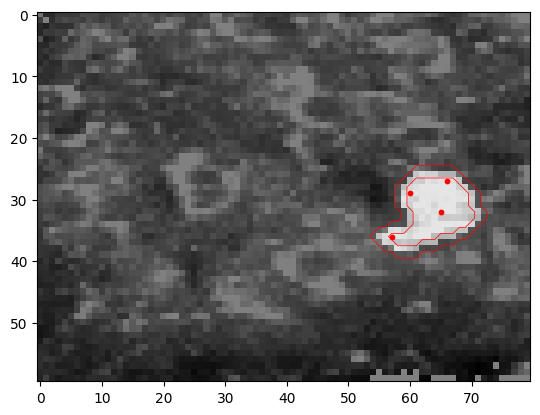

In [11]:
boundaries = find_boundaries(roi)
overlay = label2rgb(roi, bg_label=0)
plt.imshow(proj, cmap="gray")
plt.imshow(roi, cmap="nipy_spectral", alpha=0.5)
plt.scatter(coords[:, 1], coords[:, 0], s=10, c='r')
plt.contour(boundaries, colors='red', linewidths=0.5)

**Demo**: Diagnostics

In [12]:
regions = regionprops(mask)
peak_counts = []
split_flags = []

for region in regions:
    roi = mask == region.label
    cropped = proj * roi
    peaks = peak_local_max(cropped, min_distance=5)
    
    count = len(peaks)
    peak_counts.append(count)

    if count > 1:
        split_flags.append(True)
    else:
        split_flags.append(False)

**Demo** Visualize diagnostics

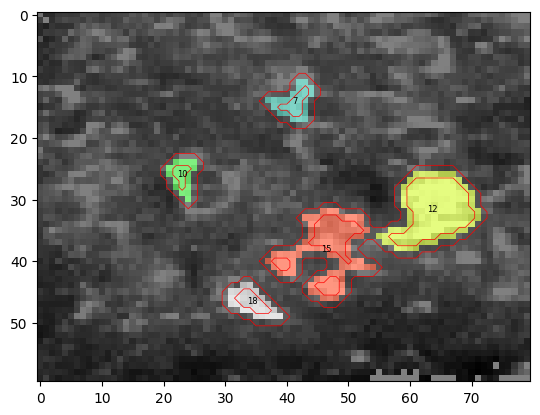

In [13]:
mask_to_show = np.zeros_like(mask)
for i, flag in enumerate(split_flags):
    if flag == True:
        mask_to_show[mask == i+1] = i+1

boundaries = find_boundaries(mask_to_show)
overlay = label2rgb(mask_to_show, bg_label=0)

plt.imshow(proj, cmap="gray")
plt.imshow(mask_to_show, cmap="nipy_spectral", alpha=0.5)
plt.contour(boundaries, colors='red', linewidths=0.5)
for region in regionprops(mask_to_show):
    y, x = region.centroid
    plt.text(x, y, str(region.label), color='black', fontsize=6, ha='center')

### **Enhancing ROI Detail Through Local Filtering**  
**Learning Goal**: Learn to improve contrast and emphasize internal features within an ROI using localized image enhancement techniques.  

In order to distinguish overlapping or closely located neuron signals, it is helpful to enhance the internal structure of each ROI. This section introduces image processing techniques such as adaptive histogram equalization and Laplacian of Gaussian filtering. These methods help reveal subtle features and boundaries that are essential for accurate sub-segmentation.

**Sub-sections:**
1. Extract ROI sub-images from the full projection  
2. Apply contrast-limited adaptive histogram equalization (CLAHE)  
3. Use Laplacian of Gaussian (LoG) filtering to highlight neuron boundaries  
4. Visualize enhanced ROI patches before and after filtering  

Start with Region 12

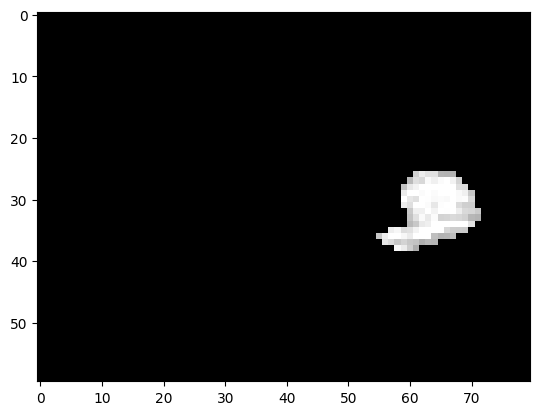

In [14]:
roi = mask == 12
roi_crop = proj * roi
coords = peak_local_max(roi_crop, min_distance=5)
plt.imshow(roi_crop, cmap='gray')

**Exercise** Enhance contrast locally within the ROI to see small variations in intensity stand out

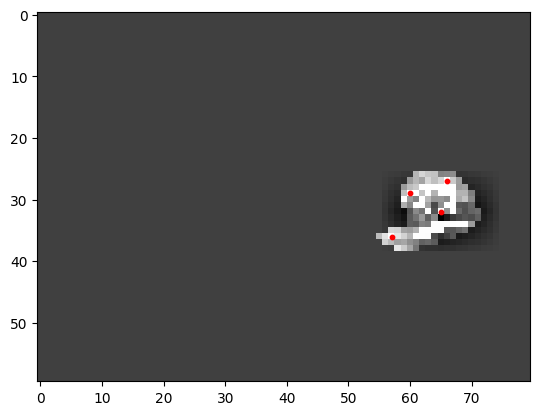

In [15]:
roi_crop_norm = roi_crop / roi_crop.max()
enhanced = equalize_adapthist(roi_crop_norm, clip_limit=0.4)
plt.imshow(enhanced, cmap='gray')
plt.scatter(coords[:, 1], coords[:, 0], s=10, c='r')

**Exercise** Detect edges and boundaries within ROI with Laplacian of Gaussian (LoG) filtering

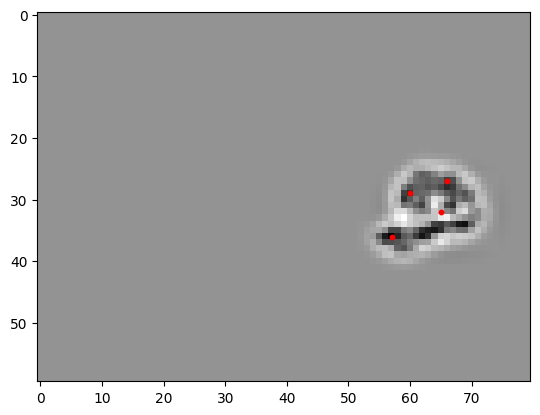

In [16]:
log_filtered = gaussian_laplace(enhanced, sigma=1.0)
plt.imshow(log_filtered, cmap='gray')
plt.scatter(coords[:, 1], coords[:, 0], s=10, c='r')

### **Segmenting Sub-Regions Within an ROI**  
**Learning Goal**: Learn to isolate meaningful sub-ROIs within a larger region using multi-peak detection and seeded segmentation.  

With enhanced images available, it is now possible to separate one region into several distinct components. This section demonstrates how to apply peak detection and seeded watershed segmentation to produce individual sub-ROIs. You will use intensity peaks to generate seed points and rely on the underlying structure to guide clean segmentation.

**Sub-sections:**
1. Detect peaks within ROI using `skimage.feature.peak_local_max`  
2. Generate initial markers using detected peaks  
3. Apply `skimage.segmentation.watershed` with distance or LoG map  
4. Label and visualize sub-ROIs with distinct colors for inspection  

Starting with local peaks detected within ROI 12

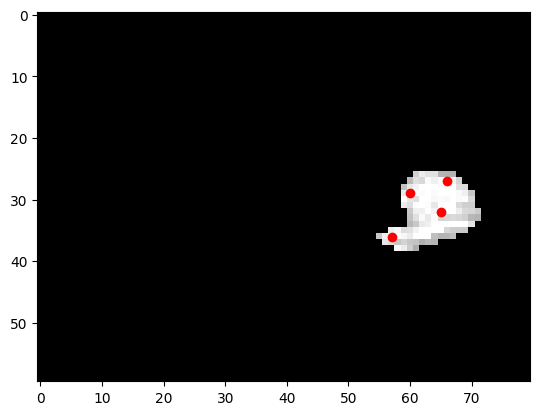

In [89]:
roi = mask == 12
roi_crop = proj * roi
coords = peak_local_max(roi_crop, min_distance=5)
plt.scatter(coords[:, 1], coords[:, 0], color='r')
plt.imshow(roi_crop, cmap='gray')

**Exercise** Convert peak coordinates into labeled seed markers for segmentation.

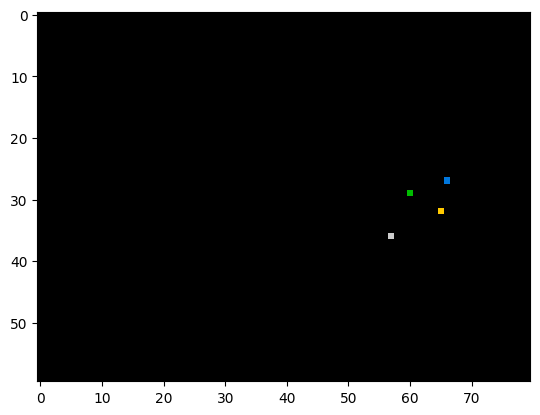

In [90]:
markers = np.zeros_like(roi_crop, dtype=np.int32)
for i, (y, x) in enumerate(coords):
    markers[y, x] = i + 1
plt.imshow(markers, cmap='nipy_spectral')

**Exercise** Apply `watershed` using the markers

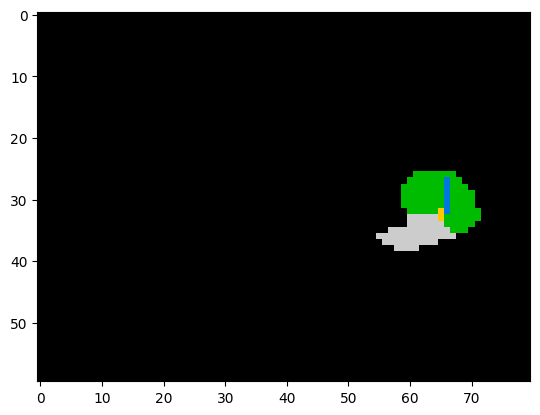

In [91]:
distance = ndi.distance_transform_edt(enhanced)
labels = watershed(-distance, markers, mask=roi)
plt.imshow(labels, cmap="nipy_spectral")

### Removing and/or Merging Oversegmented ROIs

**Exercise** There is an oversegmentation here. Remove small objects from the labels

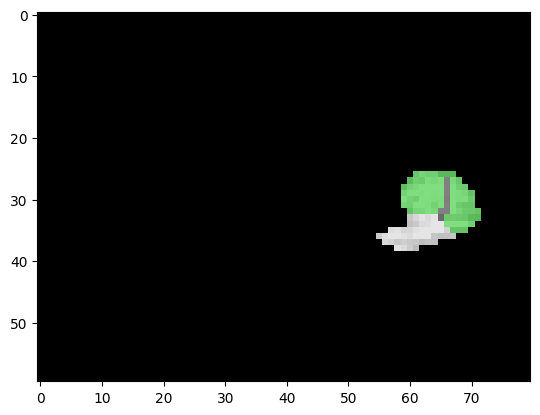

In [92]:
cleaned = remove_small_objects(labels, min_size=30)
plt.imshow(roi_crop, cmap="gray")
plt.imshow(cleaned, cmap='nipy_spectral', alpha=0.5)

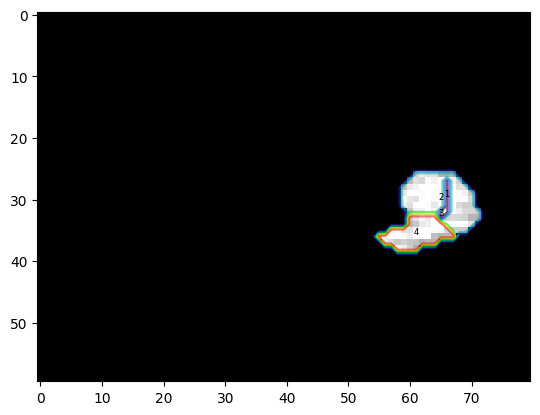

In [93]:
plt.imshow(roi_crop, cmap="gray")
plt.contour(cleaned, cmap="nipy_spectral", alpha=0.5)
for region in regionprops(labels):
    y, x = region.centroid
    plt.text(x, y, str(region.label), color='black', fontsize=6, ha='center')

**Exercise** Which regions have small areas?

In [94]:
props = regionprops(labels)
props[0].area

np.float64(6.0)

In [95]:
props[1].area

np.float64(82.0)

In [96]:
props[2].area

np.float64(2.0)

In [97]:
props[3].area

np.float64(47.0)

**Exercise** Merge 2 with 1 and assing both 3 and 4 as label 2

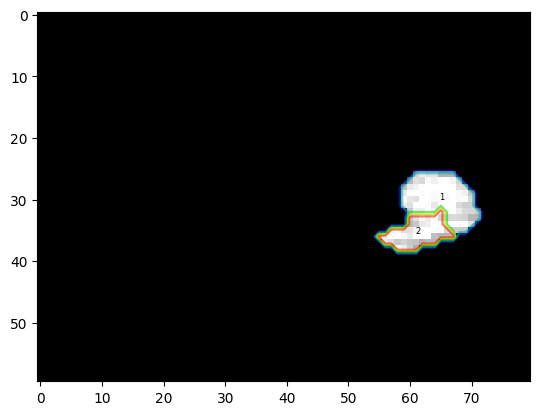

In [98]:
props = regionprops(labels)
merged = np.copy(labels)
merged[merged == 2] = 1
merged[merged == 3] = 2
merged[merged == 4] = 2

plt.imshow(roi_crop, cmap="gray")
plt.contour(merged, cmap="nipy_spectral", alpha=0.5)
for region in regionprops(merged):
    y, x = region.centroid
    plt.text(x, y, str(region.label), color='black', fontsize=6, ha='center')


### **Updating the ROI Set With Split Outputs**  
**Learning Goal**: Learn to replace and integrate split ROIs into the global segmentation mask, ensuring consistency and traceability.  

Once the sub-ROIs have been generated, the original ROI must be replaced with its refined components in the complete dataset. This section covers how to update the segmentation mask, recompute relevant ROI statistics, and export the new set for analysis. You will also track metadata about the splitting process to ensure reproducibility and clarity.

**Sub-sections:**
1. Replace original ROI mask with newly split sub-masks  
2. Recompute and append ROI statistics (centroids, sizes, labels)  
3. Overlay final ROIs on the original image for final inspection  
4. Save updated ROI masks and metadata (e.g., split origin, number of splits)  

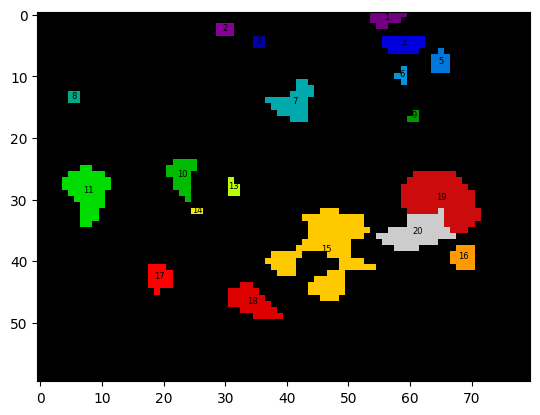

In [102]:
updated_mask = roi_full.copy()
updated_mask[updated_mask == 12] = 0
labels_shift = merged + updated_mask.max()
updated_mask[roi > 0] = labels_shift[roi > 0]

plt.imshow(updated_mask, cmap='nipy_spectral')
for region in regionprops(updated_mask):
    y, x = region.centroid
    plt.text(x, y, str(region.label), color='black', fontsize=6, ha='center')
